In [97]:
%matplotlib inline
from numpy import *
from matplotlib.pyplot import *

Consider the following one-dimensional PDE:
$$
-u_{xx}(x) = f(x)\quad\mathrm{ in }\ \Omega = (0, \pi)
$$
$$
u(x) = 0, \quad\mathrm{ on }\ \partial\Omega = \{0, \pi\}
$$

Given the following $4^{th}$ order finite difference approximation of the second order derivative:

$$u_{xx}(x_i) = \frac{-u_{i-2}+16u_{i-1}-30u_i+16u_{i+1}-u_{i+2}}{12h^2}$$

Implement a function that given the domain interval, the forcing function, the number of discretization points, the boundary conditions, returns the matrix $A$ and the the right hand side $b$.

In [98]:
def finDif(omega,f,n,bc):
    h=(omega[1]-omega[0])/(n-1)
    coord=linspace(omega[0],omega[1],n)
    A=zeros((n,n),dtype=double);b=zeros(n,dtype=double)
    tmp=array([1,-16,30,-16,1])
    A[1,:4]=array([-16,30,-16,1])
    b[1]=f(coord[1])
    for i in range(2,n-2):
        A[i,i-2:i+3]=tmp
        b[i]=f(coord[i])
    A[-2,-4:]=array([1,-16,30,-16])
    b[-2]=f(coord[-2])
    #apply boundary condition
    A[0,:]=A[:,0]=A[-1,:]=A[:,-1]=0
    A[0,0]=A[-1,-1]=1
    b[0]=bc[0];b[-1]=bc[1]
    A=A/(12*(h**2))
    # A=A*n**2/12

    return A, b

Call the function using:

In [99]:
omega = [0,pi]
f = lambda x : sin(x)
n=8
bc = [0,0]
A, b = finDif(omega, f, n, bc)

# print(A)


Implement two functions that compute the LU and the Cholesky factorization of the system matrix $A$

In [100]:
def LU(A):
    B=A.copy()
    n = B.shape[0]
    for i in range(n):
        factor = B[i+1:, i] / B[i, i]
        B[i+1:,i] = factor
        B[i+1:,i+1:] -= factor[:,newaxis]*B[i,i+1:]
    return tril(B,-1)+eye(n,dtype=double),triu(B)


L, U = LU(A)

In [101]:
def cholesky(A):
    n=A.shape[0]
    L=zeros((n,n))
    for j in range(n):
        tmp_sum=sum(L[j,:j]*L[j,:j])
        L[j,j]=sqrt(A[j,j]-tmp_sum)      
        for i in range(j+1,n):
            tmp_sum=sum(L[i,:j]*L[j,:j])
            L[i,j]=(1/L[j,j])*(A[i,j]-tmp_sum)
    return L,L.transpose()
    
HT, H = cholesky(A)

Implement forward and backward substitution functions to exploit the developed factorization methods to solve the derived linear system of equations.

In [102]:
def L_solve(L,rhs):
    n=A.shape[0]
    sol=zeros(n)
    sol[0]=b[0]/L[0,0]
    for i in range(1,n):
        sol[i]=(1/L[i,i])*(rhs[i]-dot(L[i,:i],sol[:i]))
    return sol

In [103]:
def U_solve(U,rhs):
    n=A.shape[0]
    sol=zeros(n)
    sol[-1]=b[-1]/U[-1,-1]
    for i in range(n-2,-1,-1):
        sol[i]=(1/U[i,i])*(rhs[i]-dot(U[i,i:],sol[i:]))
    return sol 


Solve the derived linear system using the implemented functions and plot the computed solution:

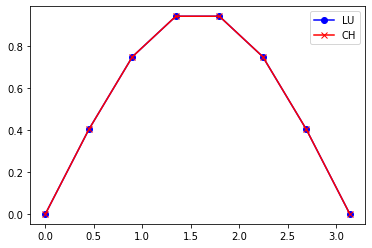

In [104]:
tmp=L_solve(L,b)
sol_LU=U_solve(U,tmp)
coords=linspace(omega[0],omega[1],n)
tmp=L_solve(HT,b)
sol_CH=U_solve(H,tmp)
coords=linspace(omega[0],omega[1],n)
title='Comparison LU and Cholesky solution'
xlabel='x'
ylabel='u(x)'
plot(coords,sol_LU,'o-b',label='LU')
plot(coords,sol_CH,'x-r',label='CH')
legend(loc='best')


Considering the new domain $\Omega = (0,1)$ and the forcing term $f(x) = x(1-x)$ with B.C. $u(x) = 0$, on $\partial \Omega = {0,1}$ produce a plot and a table where you show the decay of the error w.r.t. the number of grid points.
(The analytical solution for the above problems is $u_{an} = \frac{x^4}{12} - \frac{x^3}{6} + \frac{x}{12}$)

[[0.00064344 0.00064344 0.00064344]
 [0.00045542 0.00045542 0.00045542]
 [0.00037195 0.00037195 0.00037195]
 [0.00032217 0.00032217 0.00032217]
 [0.00028818 0.00028818 0.00028818]
 [0.00026308 0.00026308 0.00026308]
 [0.00022785 0.00022785 0.00022785]
 [0.00021483 0.00021483 0.00021483]
 [0.0002038  0.0002038  0.0002038 ]]


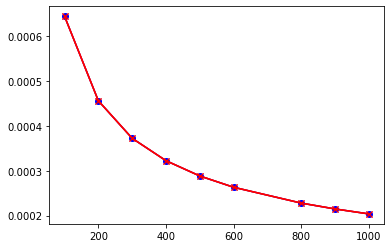

In [105]:
#TODO
omega = [0,1]
ff = lambda x : x*(1-x)
bc = [0,0]
N=9
npoints=[100,200,300,400,500,600,800,900,1000]
error=zeros((N,3))
u = lambda x : (x**4/12)-(x**3)/6+(x/12)
for idx,i in enumerate(npoints):
    coords=linspace(omega[0],omega[1],i)
    A, b = finDif(omega, ff, i, bc)
    #solve with LU
    L, U = LU(A)
    tmp=L_solve(L,b)
    sol_LU=U_solve(U,tmp)
    #solved with CH
    HT, H = cholesky(A)
    tmp=L_solve(HT,b)
    sol_CH=U_solve(H,tmp)
    #linalg
    sol_alg=linalg.solve(A,b)
    #analitical solution
    true_sol=u(coords)
    #LU-CH-error
    error[idx,0]=linalg.norm(true_sol-sol_LU)
    error[idx,1]=linalg.norm(true_sol-sol_CH)
    error[idx,2]=linalg.norm(true_sol-sol_alg)


print(error)
title='Error'
xlabel='# points'
ylabel='error'
plot(npoints,error[:,0],'o-b')
plot(npoints,error[:,1],'x-r')
plot(npoints,error[:,2],'x-r')






Exploit the derived LU factorizations to compute the condition number of the system's matrix $A$ using the original problem formulation.

In [114]:
#Power Method
def PM(A,z,tol=1e-5,nmax=20000):
    it = 0
    err = tol + 1.
    while it < nmax and err > tol:
        q = z/linalg.norm(z,2)
        z = dot(A,q)
        l = dot(q.T,z)
        err = linalg.norm(z-l*q,2)
        it += 1
    if(it==nmax):
        print("Attention: Power Method reached the maximum number of iterations,\
             for a more accurate solution increase it.")
    else:
        print("Power method converged in %d iteration ",it)
    return l

#Inverse power method
def IPM(A,z0,tol=1e-5,nmax=1000):
    L,U=LU(A)
    q = z0/linalg.norm(z0,2)
    it=0
    err = tol + 1.
    while it < nmax and err > tol:
        y=linalg.solve(L,q)         #Also L_solve could be used, prefered scipy
        x=linalg.solve(U,y)         #Also U_solve could be used, prefered scipy
        q=x/linalg.norm(x,2)
        z=dot(A,q)
        l=dot(q.T,z)
        err=linalg.norm(z-l*q,2)
        it+=1
    if(it==nmax):
        print("Attention: Inverse Power Method reached the maximum number of iterations,\
             for a more accurate solution increase it.")
    else:
        print("Inverse power method converged in %d iteration ",it)
    return l
    

def condNumb(A):
    n=A.shape[0]
    z0=random.rand(n)
    max_eig=PM(A,z0)
    min_eig=IPM(A,z0)
    zz,vv=linalg.eig(A)
    print(min(zz),max(zz),max_eig,min_eig)
    return max_eig/min_eig


omega = [0,pi]
f = lambda x : sin(x)
n=83
bc = [0,0]
A, b = finDif(omega, f, n, bc)

    
l_np, x_np = linalg.eig(A)

print(linalg.cond(A),condNumb(A))


Power method converged in %d iteration  8591
it  7 err  3.872450725533099e-06
Inverse power method converged in %d iteration  7
1.0037822708138877 3631.8506808784273 3631.850680878411 1.0037822708183348
3618.1657979815886 3618.165797964871


Implement a preconditioned Conjugant Gradient method to solve the original linear system of equations using an iterative method:

In [107]:
def conjugate_gradient(A, b, P, nmax=len(A), eps=1e-10):
    n=A.shape[0]
    x=random.rand(n)
    r=b-dot(A,x)
    p=linalg.solve(P,r)
    res=1
    it=0
    while res>eps and it<nmax:
        v1=dot(A,p)
        alpha=dot(p,r)/dot(v1,p)
        x=x+alpha*p 
        r=r-alpha*v1
        z=linalg.solve(P,r)
        beta=dot(v1,z)/dot(p,v1)
        p=z-beta*p
        res=sqrt(dot(r,r))
        it+=1
    return x,it,res

In [108]:
omega = [0,pi]
f = lambda x : sin(x)
n=1728
bc = [0,0]
A, b = finDif(omega, f, n, bc)

L,U=LU(A)
P=L.dot(L.T)
HT, H = cholesky(A)
PH=HT.dot(HT.T)

sol_pc,it,res=conjugate_gradient(A,b,P)

sol_pc_2,it2,res2=conjugate_gradient(A,b,PH)

sol_chek=linalg.solve(A,b)


print('LU res ',res, ' iterations ',it)

print('Cholesky res ',res2, ' iterations ',it2)


for i in range(n):
    if(sol_pc[i]-sol_chek[i]>1e-10):
        print('Warning solution may not be correct',sol_pc[i]-sol_chek[i])
    if(sol_pc_2[i]-sol_chek[i]>1e-10):
        print('Warning solution may not be correct',sol_pc[i]-sol_chek[i])


LU res  2.3766371634252646e-11  iterations  17
Cholesky res  5.901560373899409e-25  iterations  3


Consider the following time dependent variation of the PDE starting from the orginal problem formulation:
$$
u'(t)-u_{xx} = \alpha(t)f(x)
$$

for $t\in [0,T]$, with $\alpha(t) = \cos(t)$ and $T = 6\pi$

Use the same finite difference scheme to derive the semi-discrete formulation and solve it using a forward Euler's method.

Plot the time dependent solution solution at $x = \pi/2$, $x=1$, 
$x=\pi$


32 32 50
[1.01546429 1.01546429 1.58666296 1.58666296 3.14159265 3.14159265]
[0.         0.01478446 0.03061334 0.04648526 0.06231353 0.07807717
 0.09376    0.10934626 0.1248203  0.14016658 0.1553697  0.17041441
 0.18528559 0.19996833 0.21444789 0.22870973 0.24273954 0.25652323
 0.27004696 0.28329717 0.29626056 0.3089241  0.32127509 0.33330112
 0.34499014 0.35633039 0.3673105  0.37791945 0.38814659 0.39798164
 0.40741474 0.41643642 0.42503761 0.43320969 0.44094444 0.44823411
 0.45507138 0.46144938 0.46736171 0.47280243 0.47776609 0.48224769
 0.48624274 0.48974722 0.49275763 0.49527094 0.49728461 0.49879664
 0.49980551 0.50031019 0.50031019 0.49980551 0.49879664 0.49728461
 0.49527094 0.49275763 0.48974722 0.48624274 0.48224769 0.47776609
 0.47280243 0.46736171 0.46144938 0.45507138 0.44823411 0.44094444
 0.43320969 0.42503761 0.41643642 0.40741474 0.39798164 0.38814659
 0.37791945 0.3673105  0.35633039 0.34499014 0.33330112 0.32127509
 0.3089241  0.29626056 0.28329717 0.27004696 0.25652

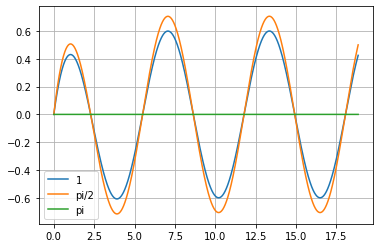

In [109]:
T=[0,6*pi]
omega = [0,pi]  #space domain
bc=[0,0]        #dirichlet bc
# ns=100         #number of spatial points
# nt=400000        #number of time "points"
ns=100
nt=100000
hs=(omega[1]-omega[0])/(ns-1)
ht=(T[1]-T[0])/(nt-1)
alpha=lambda t: cos(t)# Q2=zeros((A.shape[0],A.shape[0]))
# for i in range(A.shape[0]):
#     Q2[:,i]=Q[:,i]/linalg.norm(Q[:,i])

f = lambda x : sin(x) #x*(1-x)
#spatial coord
coord=linspace(omega[0],omega[1],ns)
#time coord
times=linspace(T[0],T[1],nt)

A=zeros((ns,ns),dtype=double)
a=-ones((ns-2,),dtype=double)
b=16*ones((ns-1,),dtype=double)
c=-30*ones((ns,),dtype=double)
A=diag(a,-2)+diag(b,-1)+diag(c)+diag(b,1)+diag(a,2)
#boundary conditions
A[0,:]=0
A[-1,:]=0
A=A/(12*(hs**2))

d0=zeros(6,dtype=int)

def get_index(coord,val):
    for id,i in enumerate(coord):
        if(i>=val):
            return(id)
            break
d0[0]=get_index(coord,1)
if(d0[0]-1<1e-8):
    d0[1]=d0[0]-1
else:
    d0[1]=d0[0]
d0[2]=get_index(coord,pi/2)
if(d0[2]-(pi/2)<1e-8):
    d0[3]=d0[2]-1
else:
    d0[3]=d0[2]
d0[4]=get_index(coord,pi)
if(d0[4]-pi<1e-8):
    d0[5]=d0[4]-1
else:
    d0[5]=d0[4]

print(d0[0],d0[1],d0[2])
print(coord[d0])

u0=zeros(ns) #supposing initial time solution
sol=zeros((nt,3))
for id,t in enumerate(times):
    rhs=f(coord)
    rhs[0]=rhs[-1]=0
    b=alpha(t)*rhs*(ht)
    I=eye(ns)
    I[0,:]=I[-1,:]=0
    ut=dot(I+ht*A,u0)+b
    u0=ut
    sol[id,0]=(u0[d0[0]]+u0[d0[1]])/2
    sol[id,1]=(u0[d0[2]]+u0[d0[3]])/2
    sol[id,2]=(u0[d0[4]]+u0[d0[5]])/2

title="Time dependent solution"
xlabel='t'
ylabel='u(x,t)'    

plot(times,sol[:,0],label='1')
plot(times,sol[:,1],label='pi/2')
plot(times,sol[:,2],label='pi')
legend(loc='best')
grid(True)
print(u0)



Given the original $Au = b$ system, implement an algorithm to compute the eigenvalues and eigenvectors of the matrix $A$. Exploit the computed LU factorization

In [120]:
omega = [0,pi]
f = lambda x : sin(x)
n=100
bc = [0,0]
A, b = finDif(omega, f, n, bc)


def eigenval(A,tol=1e-5,nmax=10000):
    T=A.copy()
    test=max(amax(abs(tril(A,-1)),axis=0))
    it=0
    while it<nmax and test>tol:
        L,U=LU(T)
        T=U@L
        it+=1
        test=max(amax(abs(tril(T,-1)),axis=0))
        if(it>=nmax):
            print('eigenvalues rich max iterations, nmax ',nmax,' tol ',test)
    return diag(T)

def eigenvec(A,eig,n,nmax=500, eps=1e-5):
    evec=eye(n)
    for id, eval in enumerate(eig):
        if id!=0 and id!=n-1: # consideration boundary conditions
            L,U=LU(A-eval*eye(n))
            it=0
            evec[:,id]=evec[:,id]/linalg.norm(evec[:,id],2)
            while  it<nmax :
                tmp=linalg.solve(L,evec[:,id])
                evec[:,id]=linalg.solve(U,tmp)
                evec[:,id]=evec[:,id]/linalg.norm(evec[:,id],2)
                it+=1
        else:
            evec[:,id]=0
            evec[id,id]=1
    return evec



eig =eigenval(A)
vals,v=linalg.eig(A)
vec=eigenvec(A,eig,A.shape[0])
# print('computed eigenvalues',eig)
# print('numpy eigenvalues',vals)
# print('computed eigenvectors',eig[1],vec[:,1])
# print('numpy eigenvectors ',vals[0],v[:,0])


computed eigenvectors 5294.594705682041 [-0.          0.00475322 -0.00923675  0.01372577 -0.01820018  0.02265635
 -0.02708974  0.03149592 -0.03587046  0.04020895 -0.04450704  0.04876041
 -0.05296479  0.05711595 -0.06120972  0.06524199 -0.06920871  0.07310589
 -0.07692961  0.08067604 -0.0843414   0.08792202 -0.09141431  0.09481474
 -0.0981199   0.10132647 -0.10443124  0.10743107 -0.11032296  0.11310401
 -0.1157714   0.11832248 -0.12075467  0.12306552 -0.12525273  0.12731408
 -0.12924751  0.13105108 -0.13272297  0.13426151 -0.13566514  0.13693246
 -0.1380622   0.13905321 -0.13990451  0.14061523 -0.14118467  0.14161225
 -0.14189755  0.14204026 -0.14204026  0.14189755 -0.14161225  0.14118467
 -0.14061523  0.13990451 -0.13905321  0.1380622  -0.13693246  0.13566514
 -0.13426151  0.13272297 -0.13105108  0.12924751 -0.12731408  0.12525273
 -0.12306552  0.12075467 -0.11832248  0.1157714  -0.11310401  0.11032296
 -0.10743107  0.10443124 -0.10132647  0.0981199  -0.09481474  0.09141431
 -0.0879220

Compute the inverse of the matrix A exploiting the derived LU factorization

In [111]:
omega = [0,pi]
f = lambda x : sin(x)
n=100
bc = [0,0]
A, b = finDif(omega, f, n, bc)

B=eye(n,dtype=double)
AINV=zeros((n,n),dtype=double)
L,U=LU(A)
for i in range(n):
    tmp=linalg.solve(L,B[:,i])
    AINV[:,i]=linalg.solve(U,tmp)

# print(AINV)
# print(linalg.inv(A))
B=linalg.inv(A)

for i in range(n):
    for j in range(n):
        if(AINV[i,j]-B[i,j]>1e-15):
            print("wrong inverse")



Consider the following Cauchy problem
$$
\begin{cases}
y'= -ty^2 \quad 0\le t \le 2\\
y(0) = 1
\end{cases}
$$
Implement a Backward Euler's method in a suitable function and solve the resulting non-linear equation using a Newton's method.

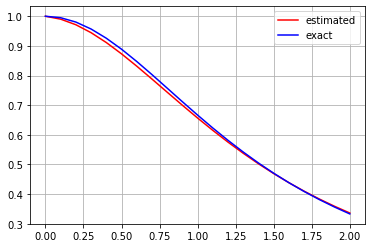

In [94]:
def newton(y0,t,h,toll=1e-6, nmax=100):
    it=0
    y=y0
    diff=1.
    while diff>=toll and it <nmax:
        y= y-(h*t*y**2+y-y0)/(1+2*h*t*y)
        diff=h*t*y**2+y-y0
        it+=1
    return y

def be(y0,t0,tf,h):
    timesteps=arange(t0,tf+1e-10, h)
    sol = zeros_like(timesteps)
    sol[0] = y0
    for i in range(1,len(sol)):
        sol[i]=newton(sol[i-1],timesteps[i],h)
    
    return sol,timesteps

sol,time=be(1,0,2,0.1)

y=1/(1+(time**2)/2)
# print(y)
# print(sol)
title='Solution'
plot(time,sol,'r', label='estimated')
plot(time,y,'b',label='exact')
xlabel='t'
ylabel='y(t)'
grid(True)
legend(loc='best')


